# Face Detection Project: Model production

This notebook is the last step in the face detection project. In this notebook, we will test the saved model on a set of 11 images. The images are taken from the internet and are not part of the training set. They have differnt sizes and aspect ratios. The model will be tested on these images to see how well it generalizes to unseen data.

In [1]:
import process as pc
import detection as dt
import dataset as ds
from IPython.core.interactiveshell import InteractiveShell

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import joblib
import cv2

import numpy as np

InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False

Here we have some functions that will help us load the model and the images, print the images, and adjust the bounding box if the image has been reshaped before the detection process.

In [2]:
def print_image(image, keypoints : np.ndarray, scores : np.ndarray):
    _, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if keypoints is None:
        pass
    elif keypoints.shape == (4,):
        rect = patches.Rectangle((keypoints[0], keypoints[1]), keypoints[2]-keypoints[0], keypoints[3]-keypoints[1], linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(keypoints[0]-1, keypoints[1]+20, f'{scores[0]:.2f}', color='g')
    else:
        for i, kp in enumerate(keypoints):
            rect = patches.Rectangle((kp[0], kp[1]), kp[2]-kp[0], kp[3]-kp[1], linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            ax.text(kp[0]-1, kp[1]+20, f'{scores[i]:.2f}', color='g')

    ax.axis('off')
    plt.show();

def get_reshape_params(image : np.ndarray):
    ratios = None
    if (image.shape[0] > 512 and image.shape[1] > 512):
        ratio_1 = 2 if image.shape[0] // 512 < 2 else image.shape[0] // 512
        ratio_2 = 2 if image.shape[1] // 512 < 2 else image.shape[1] // 512
        shapes = (image.shape[1] // ratio_2, image.shape[0] // ratio_1)
        params_reshape = {
            'resize': True,
            'image_size': shapes
        }
        ratios = [ratio_1, ratio_2]
        shapes, ratios
        img = cv2.resize(image, shapes)
        img.shape

    else:
        params_reshape = {
            'resize': False
        }
    return params_reshape, ratios

def adjust_boxes(boxes, ratios):
    if ratios:
        if boxes is None:
            pass
        elif boxes.shape == (4,):
            boxes = [boxes[i] * ratios[1] if i%2==0 else boxes[i] * ratios[0] for i in range(len(boxes))]
            boxes = np.array(boxes)
        else:
            box_shape = boxes.shape[0]
            for box in boxes:
                box = [int(box[i] * ratios[1]) if i%2==0 else int(box[i] * ratios[0]) for i in range(len(box))]
                boxes = np.vstack((boxes, box))
            box_shape
            boxes = np.delete(boxes, np.s_[:box_shape], axis=0)
        boxes
    return boxes


The images are composed of the following:
1. Group of people
2. Single person
3. Cat
4. Church

Let us start by loading the model and the images, and then we will test the model on the images, and show the results.
To process the face detection, we applied a **sliding window approach** to the images. We slide a window over the image and apply the model to the window. If the model predicts that the window contains a face, we save the window coordinates. <br>
Moreover, in order to try to detect faces of different sizes, we **resize the image to different scales** and apply the sliding window approach to each scale.<br>
Finally we apply **non-maximum suppression** to the saved coordinates to remove overlapping windows. The final coordinates are the bounding boxes of the faces in the image.

Choose an image from the list below by pressing the corresponding number or press Q to quit:
1:	Fabio_Volo.jpg
2:	Breaking_Bad.jpg
3:	Cr7.jpg
4:	Vittoria_Puccini.jpg
5:	Cat.jpeg
6:	Basilica_Sant_Antonio.jpeg
7:	Giorgia.jpeg
8:	The_Office.jpg
9:	Brunello_Cucinelli.jpg
10:	Dua_Lipa.jpg
11:	Velvet_Revolver.jpg

Selected image: ../data/final/Fabio_Volo.jpg


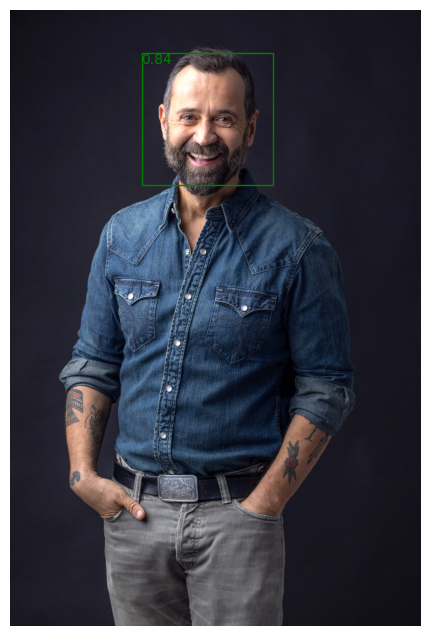

Choose an image from the list below by pressing the corresponding number or press Q to quit:
1:	Fabio_Volo.jpg
2:	Breaking_Bad.jpg
3:	Cr7.jpg
4:	Vittoria_Puccini.jpg
5:	Cat.jpeg
6:	Basilica_Sant_Antonio.jpeg
7:	Giorgia.jpeg
8:	The_Office.jpg
9:	Brunello_Cucinelli.jpg
10:	Dua_Lipa.jpg
11:	Velvet_Revolver.jpg

Selected image: ../data/final/Breaking_Bad.jpg


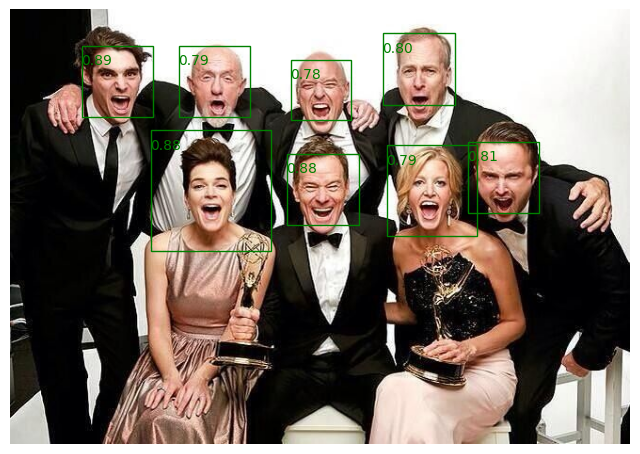

Choose an image from the list below by pressing the corresponding number or press Q to quit:
1:	Fabio_Volo.jpg
2:	Breaking_Bad.jpg
3:	Cr7.jpg
4:	Vittoria_Puccini.jpg
5:	Cat.jpeg
6:	Basilica_Sant_Antonio.jpeg
7:	Giorgia.jpeg
8:	The_Office.jpg
9:	Brunello_Cucinelli.jpg
10:	Dua_Lipa.jpg
11:	Velvet_Revolver.jpg

Selected image: ../data/final/Cr7.jpg


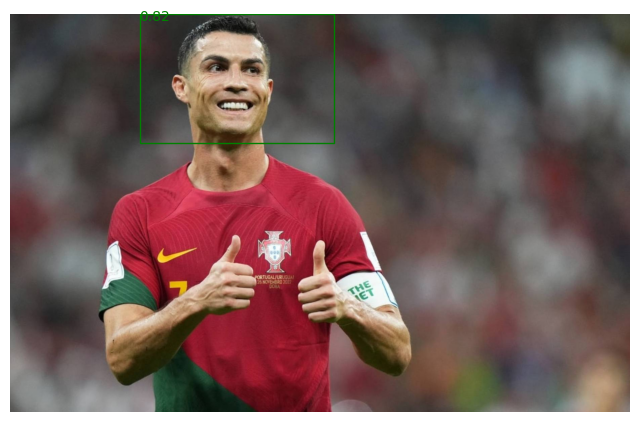

Choose an image from the list below by pressing the corresponding number or press Q to quit:
1:	Fabio_Volo.jpg
2:	Breaking_Bad.jpg
3:	Cr7.jpg
4:	Vittoria_Puccini.jpg
5:	Cat.jpeg
6:	Basilica_Sant_Antonio.jpeg
7:	Giorgia.jpeg
8:	The_Office.jpg
9:	Brunello_Cucinelli.jpg
10:	Dua_Lipa.jpg
11:	Velvet_Revolver.jpg

Selected image: ../data/final/Giorgia.jpeg


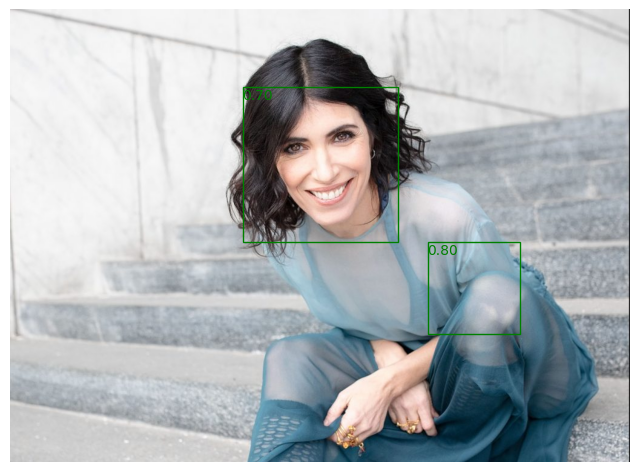

Choose an image from the list below by pressing the corresponding number or press Q to quit:
1:	Fabio_Volo.jpg
2:	Breaking_Bad.jpg
3:	Cr7.jpg
4:	Vittoria_Puccini.jpg
5:	Cat.jpeg
6:	Basilica_Sant_Antonio.jpeg
7:	Giorgia.jpeg
8:	The_Office.jpg
9:	Brunello_Cucinelli.jpg
10:	Dua_Lipa.jpg
11:	Velvet_Revolver.jpg

Selected image: ../data/final/The_Office.jpg


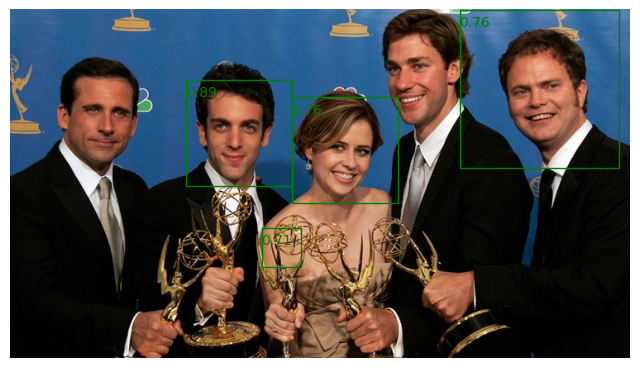

Choose an image from the list below by pressing the corresponding number or press Q to quit:
1:	Fabio_Volo.jpg
2:	Breaking_Bad.jpg
3:	Cr7.jpg
4:	Vittoria_Puccini.jpg
5:	Cat.jpeg
6:	Basilica_Sant_Antonio.jpeg
7:	Giorgia.jpeg
8:	The_Office.jpg
9:	Brunello_Cucinelli.jpg
10:	Dua_Lipa.jpg
11:	Velvet_Revolver.jpg

Selected image: ../data/final/Cat.jpeg


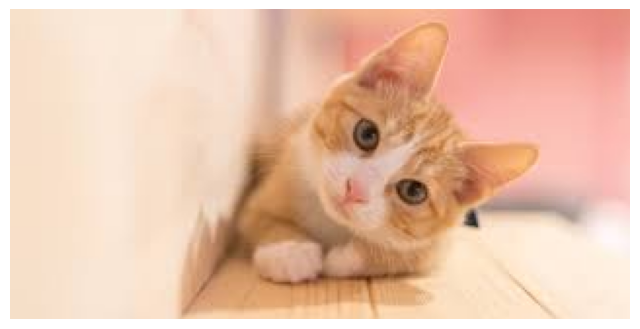

Choose an image from the list below by pressing the corresponding number or press Q to quit:
1:	Fabio_Volo.jpg
2:	Breaking_Bad.jpg
3:	Cr7.jpg
4:	Vittoria_Puccini.jpg
5:	Cat.jpeg
6:	Basilica_Sant_Antonio.jpeg
7:	Giorgia.jpeg
8:	The_Office.jpg
9:	Brunello_Cucinelli.jpg
10:	Dua_Lipa.jpg
11:	Velvet_Revolver.jpg


In [3]:
choice = ""
pipeline_save_path = ds.DATA_PATH+"/model.pkl"
while 1:
    print("Choose an image from the list below by pressing the corresponding number or press Q to quit:", flush=True)
    for i, image in enumerate(ds.get_image_list()):
        print(f"{i+1}:\t{image}", flush=True)
    choice = str(input())
    if choice.upper() == "Q":
        break
    else:
        image_path = ds.get_image_path(int(choice)-1)
        print(f"\nSelected image: {image_path}", flush=True)

        image = cv2.imread(image_path)  
        params_reshape, ratios = get_reshape_params(image)
        pipeline = joblib.load(pipeline_save_path)
        boxes, face_kp, scores = dt.detect_faces(image, pipeline, method='HOG', threshold=0.69, overlap_threshold=0.15, window_size=(96,96), step_size=(16,16),\
                                        n_keypoints=8100, **params_reshape, verbose=False, notebook=True)

        boxes = adjust_boxes(boxes, ratios)

        image = cv2.imread(image_path)
        print_image(image, boxes, scores)

As we can see, the model is able to detect faces in all the images. We can see a couple of false positives one in the image of Giorgia, and the other in The_Office image, where we also have that Michael Scott and Jim Halpert are not detected. On the other hand, the model behaves well in the image of the cat, where it does not find false positive, and in the image of Fabio Volo and Breaking Bad, where all the faces are correctly recognized with a good bounding box.
The limit of this model is due to the fact that HOG can have problems with the orientation of the faces, and the fact that the model has been trained on a relatively small dataset, where the preprocessing has been done in a simple way, and the model has been trained with a simple architecture.
The other limit is that the model has been trained on a dataset where the faces are centered and have a good aspect ratio, so the model can have problems with faces that are not centered or have a different aspect ratio.